In [1]:
%pylab inline
import math
import polyline
import itertools
import pandas as pd
import pylab as plt
from glob import glob
import seaborn as sns
from itertools import cycle
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans,AgglomerativeClustering
# --------------------------------------------------------
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

def get_rawdf(test):
    rawdf = pd.read_pickle('../data/{0:s}_latest.pdpkl'.format(test))
    return rawdf

prj = 0
tests = ['inside','outin','bigpar']
N_CLUSTERS = [8,10,10][prj] # 10 for test 0
BOUNDARIES = [(250000,270000,6210000,6227000),
              (245000,275000,6205000,6235000),
              (245000,275500,6200000,6235000)][prj]
df = get_rawdf(tests[prj])
TITLE = tests[prj]

!mkdir plots/

Populating the interactive namespace from numpy and matplotlib
mkdir: cannot create directory ‘plots/’: File exists


In [2]:
df.groupby(('mode','kind')).count()

departure  distance  duration  haversine_distance      p1  \
mode      kind                                                              
bicycling full      21694     21694     21694               21694   21694   
          step     145568    145568    145568              145568  145568   
driving   full      21690     21690     21690               21690   21690   
          step     141267    141267    141267              141267  141267   
transit   full      21694     21694     21694               21694   21694   
          step      24318     24318     24318               24318   24318   
walking   step      45029     45029     45029               45029   45029   

                    p2  polyline  walk_distance  duration[m]  distance[km]  \
mode      kind                                                               
bicycling full   21694     21694              0        21694         21694   
          step  145568         0              0       145568        145568   
driving   full   21690     21690              0        21690         21690   
          step  141267         0              0       141267        141267   
transit   full   21694     21694              0        21694         21694   
          step   24318         0              0        24318         24318   
walking   step   45029         0              0        45029         45029   

                coupled  bicycling_faster_driving    same  
mode      kind                                             
bicycling full    21694                     21694   21694  
          step   145568                    145568  145568  
driving   full    21690                     21690   21690  
          step   141267                    141267  141267  
transit   full    21694                     21694   21694  
          step    24318                     24318   24318  
walking   step    45029                     45029   45029

In [3]:
def poly(x,*coeffs):
    out = 0
    for i,c in enumerate(coeffs):
        out += x**i*c
    return out

def fitit(x,y,func,p0):
    popt,pcov = curve_fit(func,p0=p0,xdata=x,ydata=y)
    ix = np.sort(x)
    return ix,poly(ix,*popt)

def wvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].var()

def mvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].mean()

def wvarlist(x,y,dx,win):
    vy = []
    my = []
    vx = []
    for x0 in np.arange(x.min(),x.max(),dx):
        xm=x0-win
        xM=x0+win
        my.append(mvar(x,y,xm,xM))
        vy.append(wvar(x,y,xm,xM))
        vx.append(x0)
    return np.asarray(vx),np.asarray(my),np.asarray(vy)
        

In [4]:

def allclose(x,y,eps=1e-15):
    z = []
    
    for i,j in zip(x,y):
        z.append(i-j)
    try:
        for j in z:
            if abs(j)>eps:
                return False
    except TypeError:
        for j in itertools.chain.from_iterable(z):
            if abs(j)>eps:
                return False
    except:
        if abs(z)>eps: return False
    return True

In [5]:

def sample_const_ds(X,Y,dx=50):
    ds = [0,]
    ds.extend((np.diff(X)**2+np.diff(Y)**2)**.5)
    L = np.cumsum(ds)
    fx = interp1d(L,X)
    fy = interp1d(L,Y)
    Lnew = np.arange(0,L.max(),dx)
    Xnew = fx(Lnew)
    Ynew = fy(Lnew)
    return Xnew,Ynew

In [6]:

## http://wiki.openstreetmap.org/wiki/Mercator#Python_implementation
def _merc_x(lon):
    r_major=6378137.000
    return r_major*math.radians(lon)

def _merc_y(lat):
    if lat>89.5:lat=89.5
    if lat<-89.5:lat=-89.5
    r_major=6378137.000
    r_minor=6356752.3142
    temp=r_minor/r_major
    eccent=math.sqrt(1-temp**2)
    phi=math.radians(lat)
    sinphi=math.sin(phi)
    con=eccent*sinphi
    com=eccent/2
    con=((1.0-con)/(1.0+con))**com
    ts=math.tan((math.pi/2-phi)/2)/con
    y=0-r_major*math.log(ts)
    return y

merc_x=lambda lon:np.asarray(map(_merc_x,lon))
merc_y=lambda lat:np.asarray(map(_merc_y,lat))

In [7]:
def get_coupled_trips_relative_speed(mode1,mode2,df):    
    """ compatibility function to get this stuff from the data"""
    
    # selection receipt
    cpd = df[df.coupled>0]
    row_mode1 = cpd[cpd['mode']==mode1]
    row_mode2 = cpd[cpd['mode']==mode2]
    return row_mode1,row_mode2,df

bicycling,driving,df=get_coupled_trips_relative_speed('bicycling','driving',df=df)
bike = bicycling[bicycling.bicycling_faster_driving==1]
car  = driving[driving.bicycling_faster_driving==0]

nobike = bicycling[bicycling.bicycling_faster_driving==0]
nocar  = driving[driving.bicycling_faster_driving==1]


In [8]:
# cm = sns.cubehelix_palette( start=.75, gamma=.4, hue=2, light=1, dark=0.125)
# sns.palplot(cm)

In [9]:
%pylab inline
from matplotlib.font_manager import FontProperties
from cartopy import crs
from cartopy.io.img_tiles import OSM,StamenTerrain,GoogleTiles
from scipy.interpolate import griddata
from tqdm import tqdm_notebook as tqdm
font0 = FontProperties()
font0.set_family('serif')
font0.set_name('ubuntu')
class StamenToner(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/toner/{}/{}/{}.png'.format(z, x, y)
        return url

class cyclemap(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://b.tile.opencyclemap.org/cycle/{}/{}/{}.png'.format(z, x, y)
        return url

class hillshading(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://c.tiles.wmflabs.org/hillshading/{}/{}/{}.png'.format(z, x, y)
        return url
    

# imagery = OSM()
imagery = StamenToner()
# imagery =cyclemap()
# imagery = hillshading()

PC=crs.PlateCarree()
target = imagery.crs

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'allclose', 'poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
def plot_map(what,ax,bins=None):#,cx,color,lw=.75):
    
    lats=[]
    lons=[]
    
    PC=crs.PlateCarree()
    target = imagery.crs
    for ix, row in tqdm(what.iterrows()):
        path = polyline.decode(row.polyline)
        lat,lon = map(None,*path)        
        lon_merc,lat_merc,_ = target.transform_points(PC,np.asarray(lon),np.asarray(lat)).T
        lon_merc,lat_merc=sample_const_ds(lon_merc,lat_merc,dx=25)
        lats.extend(lat_merc)
        lons.extend(lon_merc)
    
    
        
    if bins:
        h2,blats,blons = np.histogram2d(lats,lons,bins=bins)
    else:
        h2,blats,blons = np.histogram2d(lats,lons,bins=200)
    bins = blats,blons
    h2/=h2.sum()
    ax.add_image(imagery, 12)
#     ax.add_image(hillshadin, 12)
    
#     pcol = ax.pcolormesh(blons,blats,h2**.5,zorder=100,alpha=.75,cmap=cm.gist_heat,vmin=0,linewidth=0,rasterized=True)
#     pcol.set_edgecolor('face')

    ax.imshow(h2**.5,zorder=100,alpha=.75,cmap=cm.gist_heat,vmin=0,extent=(blons.min(),blons.max(),blats.min(),blats.max()))
    minLAm=float(blats.min())
    minLOm=float(blons.min())
    maxLAm=float(blats.max())
    maxLOm=float(blons.max())
    
    minLA,minLO = PC.transform_point(minLOm,minLAm,target)
    maxLA,maxLO = PC.transform_point(maxLOm,maxLAm,target)
    ax.set_extent((minLA,maxLA,minLO,maxLO))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    return (minLA,maxLA,minLO,maxLO),bins
#     ax.set_aspect('equal')      

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

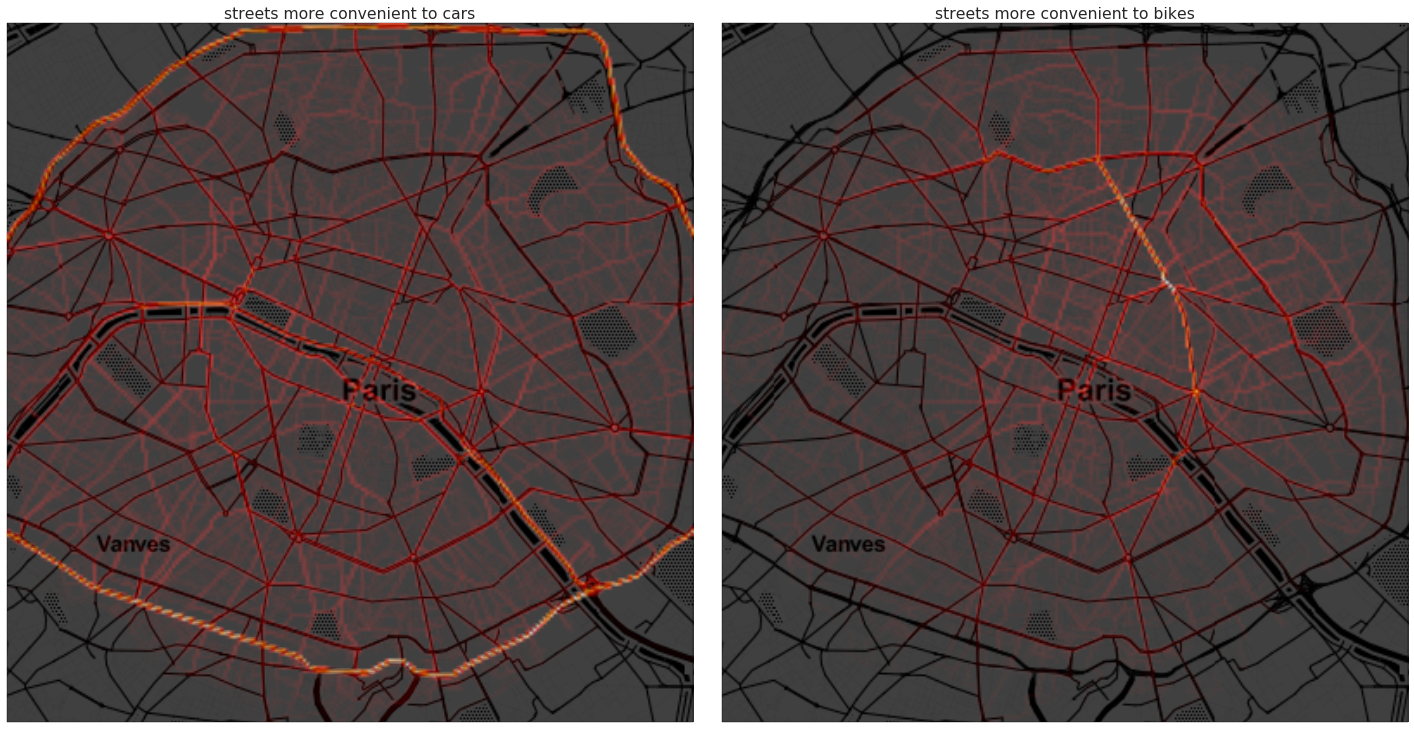

In [11]:
scale = 10
fig, (ax,bx) = plt.subplots(1,2,figsize=(2*scale,1*scale),subplot_kw=dict(projection=imagery.crs))
extent,bins = plot_map(bike,bx)
plot_map(car,ax,bins)
ax.set_extent(extent)
ax.set_title('streets more convenient to cars')
bx.set_title('streets more convenient to bikes')
fig.tight_layout()
fig.savefig('../plots/{0:s}_cfg.png'.format(TITLE),dpi=96,bbox_inches='tight')

In [12]:
# make an array with lat/lon of all paths for a given sampling distance dx
def gen_latlong(what,dx=25,SE=0):
    #dx is in meters
    #SE: straight line between start and end
    lats=[]
    lons=[]
    
    PC=crs.PlateCarree()
    target = imagery.crs
    for ix, row in tqdm(what.iterrows(),leave=0):
        path = polyline.decode(row.polyline)
        lat,lon = map(None,*path)        
        lon_merc,lat_merc,_ = target.transform_points(PC,np.asarray(lon),np.asarray(lat)).T
        if SE:
            lon_merc=lon_merc[[0,-1]]
            lat_merc=lat_merc[[0,-1]]
        lon_merc,lat_merc=sample_const_ds(lon_merc,lat_merc,dx=dx)
        lats.extend(lat_merc)
        lons.extend(lon_merc)
    return np.asarray((lats,lons)).T

In [13]:
bike_ll = gen_latlong(bike)
car_ll = gen_latlong(car)
bicycling_ll = gen_latlong(bicycling)
driving_ll = gen_latlong(driving)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [14]:
bike_ll_SE = gen_latlong(bike,SE=1)
car_ll_SE = gen_latlong(car,SE=1)
bicycling_ll_SE = gen_latlong(bicycling,SE=1)
driving_ll_SE = gen_latlong(driving,SE=1)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [15]:
def plot_hist(what,ax,nullhp=None,bins=None,dx=25,label=''):
    #dx is in meters
    lats,lons=what.T
    
    # generate rough notes
    if bins:
        h2,blats,blons = np.histogram2d(lats,lons,bins=bins,normed=0)
    else:
        h2,blats,blons = np.histogram2d(lats,lons,bins=200,normed=0)
    bins = blats,blons
    
    
    
    h2/=h2.max()
    h2 = h2.flatten()
#     h2 = h2[h2>0]

#     hnh = hnh[hnh>0]
     
    nbins=25

    if nullhp is not None:
        lats_nh,lons_nh = nullhp.T
        hnh,_,_ = np.histogram2d(lats_nh,lons_nh,bins=bins,normed=0)
        hnh/=hnh.max()
        hnh = hnh.flatten()
        ax.hist(hnh,bins=np.linspace(1./nbins,1,nbins-1),label='nullhp')
        
    ax.hist(h2,bins=np.linspace(1./nbins,1,nbins-1),label=label)
    
    return bins

def bin_width_meter(bins):
    dx = bins[0][1]-bins[0][0]
    dy = bins[1][1]-bins[1][0]
    dd = (dx+dy)/2.
    return dd

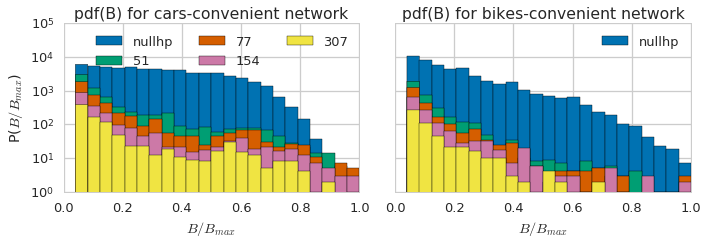

In [16]:
scale = 5
fig, (ax,bx) = plt.subplots(1,2,figsize=(2*scale,.7*scale),sharey='all')
bins = plot_hist(bike_ll,bx,nullhp=bike_ll_SE,bins=300)
dd = bin_width_meter(bins)
plot_hist(car_ll,ax,nullhp=car_ll_SE,bins=bins,label = "{0:0.0f}".format(dd))

bins = plot_hist(bike_ll,bx,bins=200)
dd = bin_width_meter(bins)
plot_hist(car_ll,ax,bins=bins,label = "{0:0.0f}".format(dd))

bins = plot_hist(bike_ll,bx,bins=100)
dd = bin_width_meter(bins)
plot_hist(car_ll,ax,bins=bins,label = "{0:0.0f}".format(dd))

bins = plot_hist(bike_ll,bx,bins=50)
dd = bin_width_meter(bins)
plot_hist(car_ll,ax,bins=bins,label = "{0:0.0f}".format(dd))

bx.set_yscale("log", nonposy='clip')
# bx.set_xscale("log", nonposy='clip')
# ax.set_yscale("log", nonposy='clip')
# ax.set_xscale("log", nonposy='clip')
bx.set_xlabel('$B/B_{max}$')
ax.set_xlabel('$B/B_{max}$')
ax.set_ylabel('P($B/B_{max}$)')
ax.set_title('pdf(B) for cars-convenient network')
bx.set_title('pdf(B) for bikes-convenient network')

ax.legend(loc=1,ncol = 3)
bx.legend(loc=1,ncol = 3)
fig.tight_layout()
fig.savefig('../plots/{0:s}_betweeness_convenient_network.png'.format(TITLE),dpi=96,bbox_inches='tight')

## Attractor

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

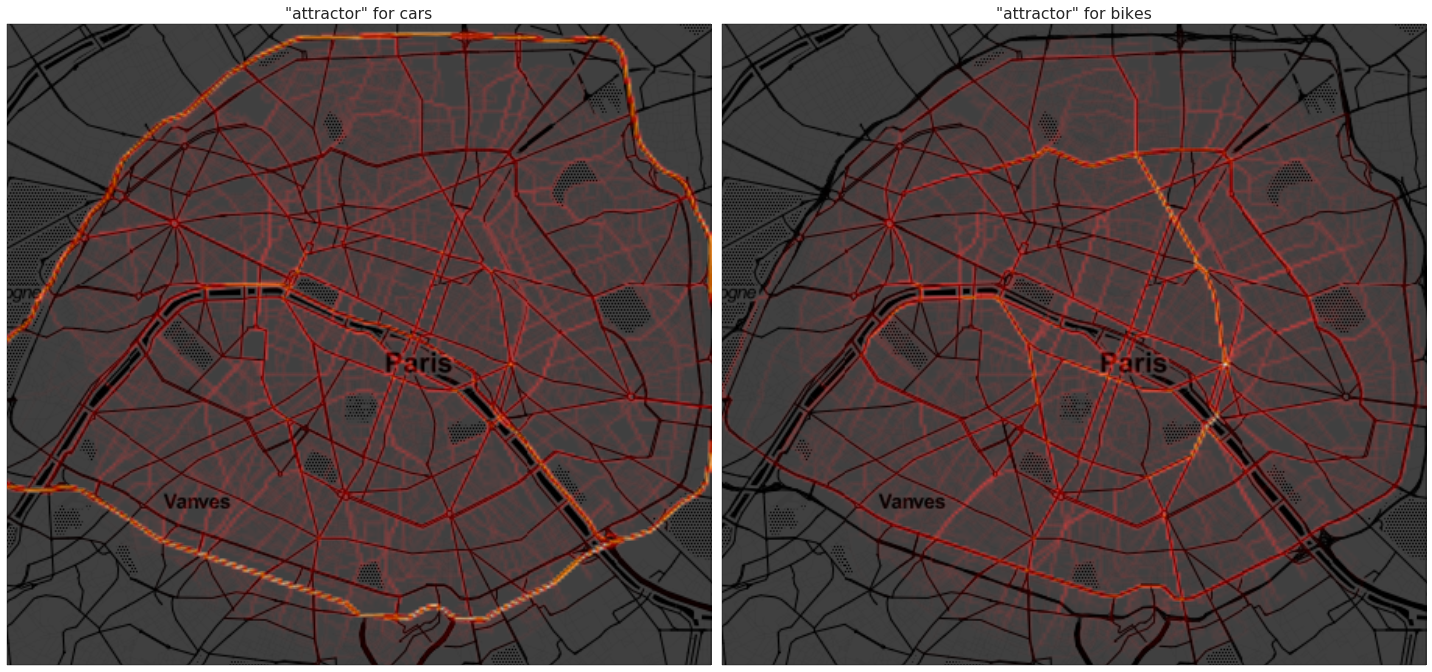

In [17]:
scale = 10
fig, (ax,bx) = plt.subplots(1,2,figsize=(2*scale,1*scale),subplot_kw=dict(projection=imagery.crs))
extent,bins = plot_map(bicycling,bx)
plot_map(driving,ax,bins)
ax.set_extent(extent)
ax.set_title('"attractor" for cars')
bx.set_title('"attractor" for bikes')
fig.tight_layout()
fig.savefig('../plots/{0:s}_attractor.png'.format(TITLE),dpi=96,bbox_inches='tight')

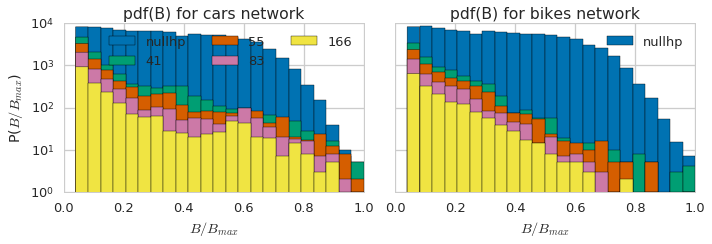

In [18]:
scale = 5
fig, (ax,bx) = plt.subplots(1,2,figsize=(2*scale,.7*scale),sharey='all')
bins = plot_hist(bicycling_ll,bx,nullhp=bicycling_ll_SE,bins=400)
dd = bin_width_meter(bins)
plot_hist(driving_ll,ax,nullhp=driving_ll_SE,bins=bins,label = "{0:0.0f}".format(dd))

bins = plot_hist(bicycling_ll,bx,bins=300)
dd = bin_width_meter(bins)
plot_hist(driving_ll,ax,bins=bins,label = "{0:0.0f}".format(dd))

bins = plot_hist(bicycling_ll,bx,bins=200)
dd = bin_width_meter(bins)
plot_hist(driving_ll,ax,bins=bins,label = "{0:0.0f}".format(dd))

bins = plot_hist(bicycling_ll,bx,bins=100)
dd = bin_width_meter(bins)
plot_hist(driving_ll,ax,bins=bins,label = "{0:0.0f}".format(dd))

bx.set_yscale("log", nonposy='clip')
# bx.set_xscale("log", nonposy='clip')
ax.set_yscale("log", nonposy='clip')
# ax.set_xscale("log", nonposy='clip')
bx.set_xlabel('$B/B_{max}$')
ax.set_xlabel('$B/B_{max}$')
ax.set_ylabel('P($B/B_{max}$)')
ax.set_title('pdf(B) for cars network')
bx.set_title('pdf(B) for bikes network')

ax.legend(loc=1,ncol = 3)
bx.legend(loc=1,ncol = 2)
fig.tight_layout()
fig.savefig('../plots/{0:s}_betweeness.png'.format(TITLE),dpi=96,bbox_inches='tight')

# Project on $R^4$ to compute clusters

In [19]:
def map2R4(what):

    out = []
    z=crs.PlateCarree()
    target = imagery.crs
    for ix, row in (what.iterrows()):
        
        be = row.p1,row.p2
        lat,lon = np.asarray([be[0][0],be[1][0]]),np.asarray([be[0][1],be[1][1]])
        start,end=target.transform_points(z,lon,lat)
        out.append([start[0],end[0],start[1],end[1]])

    return np.asarray(out)

In [20]:
brewed_colors=[(0.6509804129600526, 0.80784314870834328, 0.89019608497619618),
 (0.12572087695201239, 0.47323337360924389, 0.707327968232772),
 (0.68899655751153521, 0.8681737867056154, 0.54376011946622071),
 (0.21171857311445119, 0.63326415104024547, 0.1812226118410335),
 (0.98320646005518286, 0.5980161709820524, 0.59423301088459368),
 (0.89059593116535862, 0.10449827132271794, 0.11108035462744106),
 (0.991757017023423, 0.74648213716698608, 0.43401768935077334),
 (0.99990772780250092, 0.50099192647372981, 0.0051211073118099248),
 (0.78329874347238015, 0.68724338552531106, 0.8336793640080622),
 (0.42485198495434728, 0.25114955849507214, 0.60386007743723258),
 (0.99760092286502589, 0.99489427150464493, 0.59652443738544714),
 (0.69411766529083252, 0.3490196168422699, 0.15686275064945221),
 (0.6509804129600526, 0.80784314870834328, 0.89019608497619618),
 (0.12572087695201239, 0.47323337360924389, 0.707327968232772),
 (0.68899655751153521, 0.8681737867056154, 0.54376011946622071),
 (0.21171857311445119, 0.63326415104024547, 0.1812226118410335)]
# # import random

# # random.shuffle(brewed_colors)

In [21]:
def plot_clusters(dataset,name,title,every):
    R4=map2R4(dataset)
    km = KMeans(n_clusters=N_CLUSTERS,).fit(R4)
    labels = km.labels_

    def overmeancluster(ax,R4,colors,labels):
        for k, col in tqdm(zip(xrange(len(labels)), colors)):
            class_members = labels == k
            X = [class_members]
            xm = X.mean(axis=0)
            if np.any(np.isnan(xm)):
                continue
            ax.plot([xm[1],xm[3]],[xm[0],xm[2]], color='k',lw=8)

    scale = 10.
    colors = brewed_colors
    fig,ax = plt.subplots(1,1,figsize=(1*scale,1*scale),subplot_kw=dict(projection=imagery.crs))

    ax.add_image(imagery, 12)

    PC = crs.PlateCarree()
    minLA=np.inf
    maxLA=-np.inf
    minLO=np.inf
    maxLO=-np.inf
    count=-1
    for ix, row in tqdm(dataset.iterrows()):
        count+=1
        if count%every!=0:continue
        path = polyline.decode(row.polyline)
        lat,lon = map(None,*path)

        minLA=min(minLA,min(lat))
        maxLA=max(maxLA,max(lat))
        minLO=min(minLO,min(lon))
        maxLO=max(maxLO,max(lon))

        ax.plot(lon,lat,'-',lw=1,alpha=.3,color=colors[labels[count]],transform=PC)

    for k, col in tqdm(zip(xrange(len(labels)), colors)):
        class_members = labels == k
        X = R4[class_members]
        xm = X.mean(axis=0)
        if np.any(np.isnan(xm)):
            continue

        lat_merc = xm[0],xm[1]
        lon_merc = xm[2],xm[3]

        ax.plot(lat_merc,lon_merc, color='k',lw=8,zorder=1e9)
        ax.plot(lat_merc,lon_merc, color=colors[k],lw=4,zorder=1e9)
        ax.scatter(lat_merc[1],lon_merc[1],color='k',s=400,zorder=1e9+1,marker='>')
        ax.scatter(lat_merc[1],lon_merc[1],color=colors[k],s=300,zorder=1e9+2,marker='>')
    ax.set_extent((minLO,maxLO,minLA,maxLA))
    ax.set_title(title)
    fig.savefig('../plots/{0:s}_{1:s}_clusters.png'.format(TITLE,name),dpi=96,bbox_inches='tight')

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=16), HTML(value=u'')))

/home/astyonax/.anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/astyonax/.anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


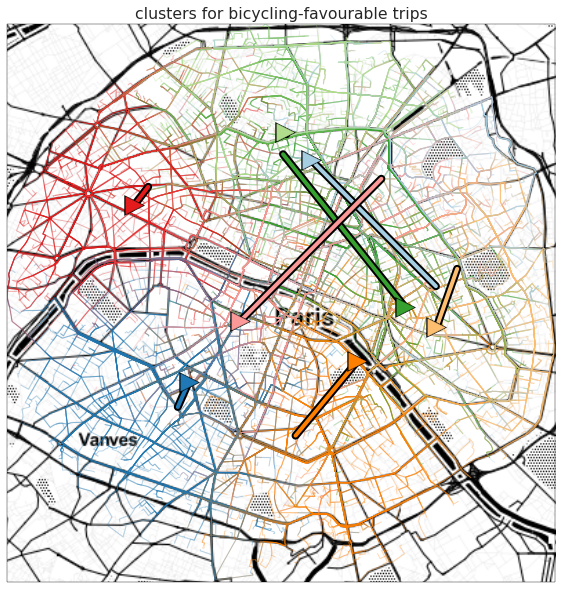

In [22]:
plot_clusters(dataset = bike,
name = 'bike',
title = 'clusters for bicycling-favourable trips',
every = 1)

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=16), HTML(value=u'')))

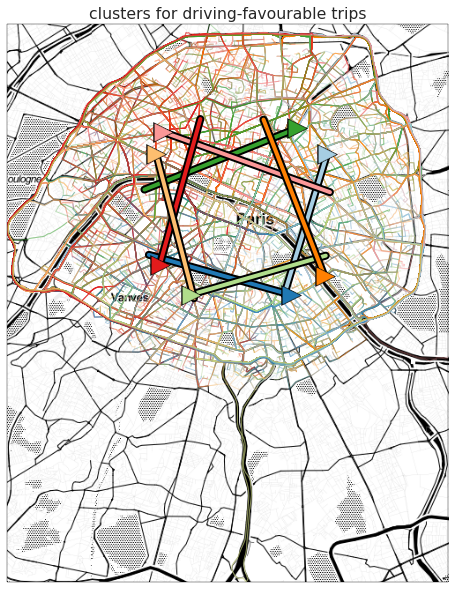

In [23]:
plot_clusters(dataset = car,
name = 'car',
title = 'clusters for driving-favourable trips',
every = 5)